In [2]:
from functools import partial
from typing import Callable

import jax
import jax.numpy as jnp
import jax.scipy.stats as jstats
import matplotlib.pyplot as plt
import pandas as pd
from jax import Array

In [3]:
@partial(jax.jit)
def unnormalized_p(x: Array) -> Array:
    return (
        ((x >= -3) & (x <= 3))
        * jnp.exp(-0.5 * (x**2))
        * (jnp.sin(x) ** 2 + 3 * jnp.cos(x) ** 2 * jnp.sin(7 * x) ** 2 + 1)
    )

In [4]:
k_uniform = unnormalized_p(jnp.linspace(-3, 3, num=1000)).max().item() / (1 / 6) * 1.001


@partial(jax.jit, static_argnums=1)
def proposal_uniform(key: Array, batch_size: int = 100) -> tuple[Array, Array]:
    return jnp.full((batch_size,), 1 / 6), jax.random.uniform(
        key, (batch_size,), minval=-3, maxval=3
    )

In [5]:
k_normal = 9.8  # trial and error


@partial(jax.jit, static_argnums=(1,))
def proposal_normal(key: Array, batch_size: int = 100) -> tuple[Array, Array]:
    samples = jax.random.normal(key, (batch_size,))
    density = jstats.norm.pdf(samples, 0, 1)
    return density, samples

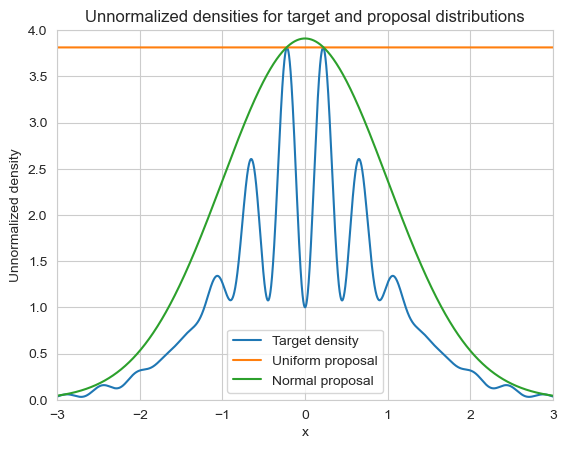

In [6]:
df_densities = pd.DataFrame(
    {
        "Target density": jax.vmap(unnormalized_p)(jnp.linspace(-3, 3, num=10000)),
        "Uniform proposal": jnp.full((10000,), 1 / 6 * k_uniform),
        "Normal proposal": jstats.norm.pdf(jnp.linspace(-3, 3, num=10000), 0, 1)
        * k_normal,
        "x": jnp.linspace(-3, 3, num=10000),
    }
)
df_densities.plot.line(
    y=["Target density", "Uniform proposal", "Normal proposal"],
    x="x",
    ylabel="Unnormalized density",
    title="Unnormalized densities for target and proposal distributions",
    xlim=(-3, 3),
    ylim=(0, 4),
)
plt.plot()
assert (df_densities["Target density"] < df_densities["Uniform proposal"]).all()
assert (df_densities["Target density"] < df_densities["Normal proposal"]).all()

In [7]:
@partial(jax.jit, static_argnames=("p_tilde", "proposal_dist", "fn", "k", "batch_size"))
def rejection_sample_expectation(
    key: jnp.ndarray,
    *,
    p_tilde: Callable,
    proposal_dist: Callable,
    fn: Callable,
    k: float,
    batch_size: int = 100,
) -> Array:
    gen_key, u_key = jax.random.split(key)
    prop_density, prop_samples = proposal_dist(gen_key, batch_size=batch_size)
    target_density = p_tilde(prop_samples)
    u_vals = jax.random.uniform(u_key, (batch_size,))
    pkq_ratio = target_density / (k * prop_density)
    return jnp.mean(fn(prop_samples), where=u_vals < pkq_ratio)


rejection_sample_expectation(
    key=jax.random.key(1),
    p_tilde=unnormalized_p,
    proposal_dist=proposal_uniform,
    fn=lambda x: x**2,
    k=k_uniform,
)

Array(0.7780094, dtype=float32)

In [8]:
@partial(jax.jit, static_argnames=("p_tilde", "proposal_dist", "fn", "batch_size"))
def self_norm_expectation(
    key: jnp.ndarray,
    *,
    p_tilde: Callable,
    proposal_dist: Callable,
    fn: Callable,
    batch_size: int = 100,
) -> Array:
    prop_density, prop_samples = proposal_dist(key, batch_size=batch_size)
    target_density = p_tilde(prop_samples)
    pq_ratio = target_density / prop_density
    pq_ratio_norm = pq_ratio / pq_ratio.sum(0, keepdims=True)
    vals = fn(prop_samples)
    return jnp.average(vals, axis=0, weights=pq_ratio_norm)


self_norm_expectation(
    key=jax.random.key(1),
    p_tilde=unnormalized_p,
    proposal_dist=proposal_normal,
    fn=lambda x: x**2,
)

Array(0.94849336, dtype=float32)

In [9]:
def mean_var_estimator(
    key: jnp.ndarray,
    est: Callable,
    batch_sizes: tuple[int, ...] = (10, 31, 100, 310, 1_000),
    estimator_calls: int = 100_000,
    **estimator_kwargs,
) -> pd.DataFrame:
    res = {}
    for batch_size in batch_sizes:
        batch_key, key = jax.random.split(key)
        est_batch = partial(est, batch_size=batch_size, **estimator_kwargs)
        batch_keys = jax.random.split(batch_key, estimator_calls)

        estimates = jax.vmap(est_batch)(batch_keys)
        res[batch_size] = {
            "mean": jnp.nanmean(estimates).item(),
            "std": jnp.nanstd(estimates).item(),
        }
    return pd.DataFrame(res).T.reset_index(names="size")

In [10]:
seed = 0
df_rej_uniform = mean_var_estimator(
    key=jax.random.key(seed),
    est=rejection_sample_expectation,
    p_tilde=unnormalized_p,
    proposal_dist=proposal_uniform,
    k=k_uniform,
    fn=lambda x: x**2,
)
df_rej_gaussian = mean_var_estimator(
    key=jax.random.key(seed),
    est=rejection_sample_expectation,
    p_tilde=unnormalized_p,
    proposal_dist=proposal_normal,
    k=k_normal,
    fn=lambda x: x**2,
)
df_import_gaussian = mean_var_estimator(
    key=jax.random.key(seed),
    est=self_norm_expectation,
    p_tilde=unnormalized_p,
    proposal_dist=proposal_uniform,
    fn=lambda x: x**2,
)

In [11]:
df_import_gaussian

,size,mean,std
0,10,1.039260,0.460139
1,31,0.950853,0.221833
2,100,0.925484,0.117599
3,310,0.918137,0.065573
4,1000,0.915778,0.036423


In [14]:
df_rej_uniform.to_parquet("data/df_rej_uniform.pq")
df_rej_gaussian.to_parquet("data/df_rej_gaussian.pq")
df_import_gaussian.to_parquet("data/df_import_gaussian.pq")

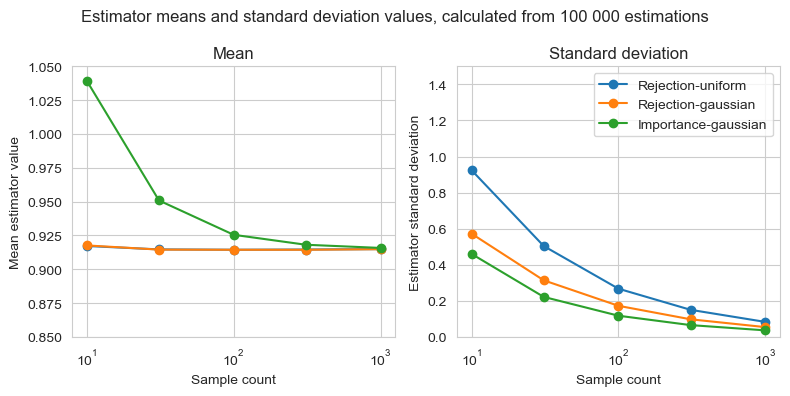

In [12]:
_, (ax_means, ax_stds) = plt.subplots(ncols=2, tight_layout=True, figsize=(8, 4))

for data, label in (
    (df_rej_uniform, "Rejection-uniform"),
    (df_rej_gaussian, "Rejection-gaussian"),
    (df_import_gaussian, "Importance-gaussian"),
):
    data.plot.line(
        x="size",
        y="mean",
        marker="o",
        ylim=(0.85, 1.05),
        ax=ax_means,
    )
    data.plot.line(
        x="size",
        y="std",
        marker="o",
        label=label,
        ylim=(0, 1.5),
        ax=ax_stds,
    )
plt.suptitle(
    "Estimator means and standard deviation values,"
    " calculated from 100 000 estimations"
)
ax_means.set(
    xscale="log",
    ylabel="Mean estimator value",
    title="Mean",
    xlabel="Sample count",
)
ax_stds.set(
    xscale="log",
    ylabel="Estimator standard deviation",
    title="Standard deviation",
    xlabel="Sample count",
)
ax_means.get_legend().remove()